# Análise de Confiabilidade - Alpha de Cronbach

Este notebook calcula o **Alpha de Cronbach** para avaliar a consistência interna de diferentes blocos de questões do questionário.

## Blocos Analisados:

1. **Bloco 1 - Conhecimento antes do curso** (7 questões)
2. **Bloco 2 - Conhecimento depois do curso** (7 questões)
3. **Bloco 3 - Motivação** (5 questões)
4. **Bloco 4 - Percepção de contribuição** (1 questão - análise especial)

## Métricas Calculadas:

- Alpha de Cronbach (α)
- Correlações item-total
- Alpha se item deletado
- Estatísticas descritivas


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo para artigos acadêmicos
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Computer Modern Roman'],
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
    'patch.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Paleta de cores para impressão (acessível e profissional)
colors_academic = {
    'primary': '#2C3E50',      # Azul escuro
    'secondary': '#34495E',     # Cinza azulado
    'accent1': '#3498DB',      # Azul
    'accent2': '#E74C3C',      # Vermelho
    'accent3': '#27AE60',      # Verde
    'accent4': '#F39C12',      # Laranja
    'light': '#ECF0F1',        # Cinza claro
    'dark': '#1A1A1A'          # Preto
}


In [2]:
# Função para calcular Alpha de Cronbach
def cronbach_alpha(df):
    """
    Calcula o Alpha de Cronbach para um conjunto de itens.
    
    Parâmetros:
    df: DataFrame com os itens nas colunas
    
    Retorna:
    alpha: Valor do Alpha de Cronbach
    """
    df_clean = df.dropna()
    if df_clean.shape[0] < 2:
        return np.nan
    
    # Número de itens
    k = df_clean.shape[1]
    
    if k < 2:
        return np.nan
    
    # Variância de cada item
    item_var = df_clean.var(axis=0, ddof=1)
    
    # Variância total (soma dos itens)
    total_var = df_clean.sum(axis=1).var(ddof=1)
    
    # Calcular alpha
    alpha = (k / (k - 1)) * (1 - item_var.sum() / total_var)
    
    return alpha

# Função para calcular correlações item-total
def item_total_correlation(df):
    """
    Calcula a correlação de cada item com o total (sem o próprio item).
    
    Parâmetros:
    df: DataFrame com os itens nas colunas
    
    Retorna:
    correlations: Series com correlações item-total
    """
    df_clean = df.dropna()
    correlations = {}
    
    for col in df_clean.columns:
        # Total sem o item atual
        total_sem_item = df_clean.drop(columns=[col]).sum(axis=1)
        # Correlação item-total
        corr, _ = pearsonr(df_clean[col], total_sem_item)
        correlations[col] = corr
    
    return pd.Series(correlations)

# Função para calcular alpha se item deletado
def alpha_if_deleted(df):
    """
    Calcula o alpha se cada item for removido.
    
    Parâmetros:
    df: DataFrame com os itens nas colunas
    
    Retorna:
    alphas: Series com alpha se item deletado
    """
    df_clean = df.dropna()
    alphas = {}
    
    for col in df_clean.columns:
        df_sem_item = df_clean.drop(columns=[col])
        if df_sem_item.shape[1] >= 2:
            alphas[col] = cronbach_alpha(df_sem_item)
        else:
            alphas[col] = np.nan
    
    return pd.Series(alphas)


In [3]:
# Carregar os dados
df = pd.read_csv("../csv/feedback-v2.csv")
df.columns = df.columns.str.strip()

print(f"Shape do dataset: {df.shape}")
print(f"Total de colunas: {len(df.columns)}")


Shape do dataset: (21, 38)
Total de colunas: 38


## Bloco 1: Conhecimento Antes do Curso

Preparar as 7 questões sobre conhecimento antes da disciplina.


In [4]:
# Mapear questões de conhecimento antes
# Escala: 0=Nenhum, 1=Baixo, 2=Médio, 3=Alto
conhecimento_scale = {
    "Nenhum. Não conhecia.": 0,
    "Baixo. Adquiri conhecimentos básicos em aulas ou livros.": 1,
    "Médio. Já havia utilizado em projetos de pesquisa.": 2,
    "Alto. Já havia utilizado em cinco ou mais projetos.": 3
}

# Mapear todas as variações possíveis
conhecimento_scale_extended = {
    "Nenhum. Não conhecia.": 0,
    "Nenhum": 0,
    "Baixo. Adquiri conhecimentos básicos em aulas ou livros.": 1,
    "Baixo": 1,
    "Médio. Já havia utilizado em projetos de pesquisa.": 2,
    "Médio": 2,
    "Alto. Já havia utilizado em cinco ou mais projetos.": 3,
    "Alto": 3
}

# Colunas de conhecimento antes
bloco1_cols = [
    'Qual seu nível de conhecimento sobre tipos de estudos experimentais (primários, secundários e terciários) antes da disciplina?',
    'Qual seu nível de conhecimento sobre experimento controlado antes da disciplina?',
    'Qual seu nível de conhecimento sobre estudo de caso antes da disciplina?',
    'Qual seu nível de conhecimento sobre Survey antes da disciplina?',
    'Qual seu nível de conhecimento sobre análise estatística de experimentos antes da disciplina?',
    'Qual seu nível de conhecimento sobre análise qualitativa antes da disciplina?',
    'Qual seu nível de conhecimento sobre revisão sistemática da literatura (RSL) antes da disciplina?'
]

# Criar DataFrame para Bloco 1
bloco1 = pd.DataFrame()
for col in bloco1_cols:
    if col in df.columns:
        # Tentar mapear com diferentes variações
        bloco1[col] = df[col].map(conhecimento_scale_extended)
        # Se não mapeou, tentar valores numéricos diretos
        if bloco1[col].isna().all():
            bloco1[col] = pd.to_numeric(df[col], errors='coerce')

# Renomear colunas para nomes mais curtos
bloco1.columns = [
    'Estudos experimentais (antes)',
    'Experimento controlado (antes)',
    'Estudo de caso (antes)',
    'Survey (antes)',
    'Análise estatística (antes)',
    'Análise qualitativa (antes)',
    'RSL (antes)'
]

print("Bloco 1 - Conhecimento Antes:")
print(f"Shape: {bloco1.shape}")
print(f"\nValores únicos por item:")
for col in bloco1.columns:
    print(f"  {col}: {sorted(bloco1[col].dropna().unique())}")


Bloco 1 - Conhecimento Antes:
Shape: (21, 7)

Valores únicos por item:
  Estudos experimentais (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(4)]
  Experimento controlado (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(5)]
  Estudo de caso (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  Survey (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(5)]
  Análise estatística (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  Análise qualitativa (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  RSL (antes): [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5)]


## Bloco 2: Conhecimento Depois do Curso

Preparar as 7 questões sobre conhecimento depois da disciplina.


In [5]:
# Colunas de conhecimento depois
bloco2_cols = [
    'Qual seu nível de conhecimento sobre tipos de estudos experimentais (primários, secundários e terciários) após da disciplina?',
    'Qual seu nível de conhecimento sobre experimento controlado após a disciplina?',
    'Qual seu nível de conhecimento sobre estudo de caso após a disciplina?',
    'Qual seu nível de conhecimento sobre Survey após a disciplina?',
    'Qual seu nível de conhecimento sobre análise estatística de experimentos após a disciplina?',
    'Qual seu nível de conhecimento sobre análise qualitativa após a disciplina?',
    'Qual seu nível de conhecimento sobre revisão sistemática da literatura (RSL) após a disciplina?'
]

# Criar DataFrame para Bloco 2
bloco2 = pd.DataFrame()
for col in bloco2_cols:
    if col in df.columns:
        bloco2[col] = df[col].map(conhecimento_scale_extended)
        if bloco2[col].isna().all():
            bloco2[col] = pd.to_numeric(df[col], errors='coerce')

# Renomear colunas
bloco2.columns = [
    'Estudos experimentais (depois)',
    'Experimento controlado (depois)',
    'Estudo de caso (depois)',
    'Survey (depois)',
    'Análise estatística (depois)',
    'Análise qualitativa (depois)',
    'RSL (depois)'
]

print("Bloco 2 - Conhecimento Depois:")
print(f"Shape: {bloco2.shape}")
print(f"\nValores únicos por item:")
for col in bloco2.columns:
    print(f"  {col}: {sorted(bloco2[col].dropna().unique())}")


Bloco 2 - Conhecimento Depois:
Shape: (21, 7)

Valores únicos por item:
  Estudos experimentais (depois): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  Experimento controlado (depois): [np.int64(3), np.int64(4), np.int64(5)]
  Estudo de caso (depois): [np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
  Survey (depois): [np.int64(3), np.int64(4), np.int64(5)]
  Análise estatística (depois): [np.int64(3), np.int64(4), np.int64(5)]
  Análise qualitativa (depois): [np.int64(3), np.int64(4), np.int64(5)]
  RSL (depois): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


## Bloco 3: Motivação

Preparar as 5 questões de motivação.


In [6]:
# Escala de motivação: 1=Desmotivado, 2=Neutro, 3=Motivado, 4=Muito motivado
motiv_scale = {
    "Desmotivado(a)": 1,
    "Neutro(a)": 2,
    "Motivado(a)": 3,
    "Muito motivado(a)": 4
}

# Colunas de motivação
bloco3_cols = [
    "Estudo de caso",
    "Survey", 
    "Revisão Sistemática da Literatura (RSL)", 
    "Análise Estatística de Experimentos", 
    "Análise Qualitativa"
]

# Criar DataFrame para Bloco 3
bloco3 = pd.DataFrame()
for col in bloco3_cols:
    if col in df.columns:
        bloco3[col] = df[col].map(motiv_scale)
        if bloco3[col].isna().all():
            bloco3[col] = pd.to_numeric(df[col], errors='coerce')

print("Bloco 3 - Motivação:")
print(f"Shape: {bloco3.shape}")
print(f"\nValores únicos por item:")
for col in bloco3.columns:
    print(f"  {col}: {sorted(bloco3[col].dropna().unique())}")


Bloco 3 - Motivação:
Shape: (21, 5)

Valores únicos por item:
  Estudo de caso: [np.int64(2), np.int64(3), np.int64(4)]
  Survey: [np.int64(2), np.int64(3), np.int64(4)]
  Revisão Sistemática da Literatura (RSL): [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
  Análise Estatística de Experimentos: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
  Análise Qualitativa: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [7]:
# Escala de percepção: 1=Discordo totalmente, 2=Discordo, 3=Neutro, 4=Concordo, 5=Concordo totalmente
contrib_scale = {
    "Discordo totalmente": 1,
    "Discordo": 2,
    "Neutro": 3,
    "Concordo": 4,
    "Concordo totalmente": 5
}

# Coluna de percepção de contribuição
bloco4_col = 'Você acredita que a disciplina vai contribuir para sua formação?'

# Criar DataFrame para Bloco 4
bloco4 = pd.DataFrame()
if bloco4_col in df.columns:
    bloco4[bloco4_col] = df[bloco4_col].map(contrib_scale)
    if bloco4[bloco4_col].isna().all():
        bloco4[bloco4_col] = pd.to_numeric(df[bloco4_col], errors='coerce')
    bloco4.columns = ['Percepção de Contribuição']

print("Bloco 4 - Percepção de Contribuição:")
print(f"Shape: {bloco4.shape}")
print(f"\nValores únicos:")
print(f"  {bloco4.columns[0]}: {sorted(bloco4.iloc[:, 0].dropna().unique())}")
print(f"\nNota: Bloco 4 tem apenas 1 item, então não é possível calcular Alpha de Cronbach.")
print("Alpha de Cronbach requer pelo menos 2 itens.")


Bloco 4 - Percepção de Contribuição:
Shape: (21, 1)

Valores únicos:
  Percepção de Contribuição: [np.int64(4), np.int64(5)]

Nota: Bloco 4 tem apenas 1 item, então não é possível calcular Alpha de Cronbach.
Alpha de Cronbach requer pelo menos 2 itens.


## Tratamento de Missing Values

Substituir valores faltantes pela média do item.


In [8]:
# Função para tratar missing values (substituir por média do item)
def tratar_missing_values(df_bloco):
    """
    Substitui valores faltantes pela média do item.
    """
    df_clean = df_bloco.copy()
    
    for col in df_clean.columns:
        media = df_clean[col].mean()
        df_clean[col] = df_clean[col].fillna(media)
    
    return df_clean

# Aplicar tratamento de missing values
bloco1_clean = tratar_missing_values(bloco1)
bloco2_clean = tratar_missing_values(bloco2)
bloco3_clean = tratar_missing_values(bloco3)
bloco4_clean = tratar_missing_values(bloco4)

print("Missing values tratados:")
print(f"Bloco 1 - Antes: {bloco1.isna().sum().sum()}, Depois: {bloco1_clean.isna().sum().sum()}")
print(f"Bloco 2 - Antes: {bloco2.isna().sum().sum()}, Depois: {bloco2_clean.isna().sum().sum()}")
print(f"Bloco 3 - Antes: {bloco3.isna().sum().sum()}, Depois: {bloco3_clean.isna().sum().sum()}")
print(f"Bloco 4 - Antes: {bloco4.isna().sum().sum()}, Depois: {bloco4_clean.isna().sum().sum()}")


Missing values tratados:
Bloco 1 - Antes: 0, Depois: 0
Bloco 2 - Antes: 0, Depois: 0
Bloco 3 - Antes: 0, Depois: 0
Bloco 4 - Antes: 0, Depois: 0


## Verificação de Escalas

Garantir que todas as respostas estão no mesmo formato numérico e verificar se há inversão de escala.


In [9]:
# Verificar escalas e valores
print("="*60)
print("VERIFICAÇÃO DE ESCALAS")
print("="*60)

print("\nBloco 1 - Conhecimento Antes:")
print(f"  Escala esperada: 0-3")
print(f"  Valores encontrados: {sorted(bloco1_clean.values.flatten())}")
print(f"  Min: {bloco1_clean.min().min()}, Max: {bloco1_clean.max().max()}")

print("\nBloco 2 - Conhecimento Depois:")
print(f"  Escala esperada: 0-3")
print(f"  Valores encontrados: {sorted(bloco2_clean.values.flatten())}")
print(f"  Min: {bloco2_clean.min().min()}, Max: {bloco2_clean.max().max()}")

print("\nBloco 3 - Motivação:")
print(f"  Escala esperada: 1-4")
print(f"  Valores encontrados: {sorted(bloco3_clean.values.flatten())}")
print(f"  Min: {bloco3_clean.min().min()}, Max: {bloco3_clean.max().max()}")

print("\nBloco 4 - Percepção de Contribuição:")
print(f"  Escala esperada: 1-5")
print(f"  Valores encontrados: {sorted(bloco4_clean.values.flatten())}")
print(f"  Min: {bloco4_clean.min().min()}, Max: {bloco4_clean.max().max()}")

# Verificar se há necessidade de inverter escala (correlações negativas indicam inversão)
print("\n" + "="*60)
print("VERIFICAÇÃO DE INVERSÃO DE ESCALA")
print("="*60)
print("(Correlações negativas podem indicar necessidade de inversão)")


VERIFICAÇÃO DE ESCALAS

Bloco 1 - Conhecimento Antes:
  Escala esperada: 0-3
  Valores encontrados: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np

## Cálculo do Alpha de Cronbach

Calcular o Alpha de Cronbach para cada bloco.


In [10]:
# Calcular Alpha de Cronbach para cada bloco
resultados = {}

# Bloco 1
alpha1 = cronbach_alpha(bloco1_clean)
resultados['Bloco 1 - Conhecimento Antes'] = {
    'alpha': alpha1,
    'n_items': bloco1_clean.shape[1],
    'n_respondentes': bloco1_clean.shape[0]
}

# Bloco 2
alpha2 = cronbach_alpha(bloco2_clean)
resultados['Bloco 2 - Conhecimento Depois'] = {
    'alpha': alpha2,
    'n_items': bloco2_clean.shape[1],
    'n_respondentes': bloco2_clean.shape[0]
}

# Bloco 3
alpha3 = cronbach_alpha(bloco3_clean)
resultados['Bloco 3 - Motivação'] = {
    'alpha': alpha3,
    'n_items': bloco3_clean.shape[1],
    'n_respondentes': bloco3_clean.shape[0]
}

# Bloco 4 (não pode calcular alpha com 1 item)
resultados['Bloco 4 - Percepção de Contribuição'] = {
    'alpha': np.nan,
    'n_items': 1,
    'n_respondentes': bloco4_clean.shape[0],
    'observacao': 'Alpha requer pelo menos 2 itens'
}

# Criar tabela de resultados
tabela_resultados = pd.DataFrame(resultados).T
tabela_resultados['alpha'] = tabela_resultados['alpha'].round(3)

print("="*70)
print("RESULTADOS DO ALPHA DE CRONBACH")
print("="*70)
print(tabela_resultados.to_string())
print("\n" + "="*70)
print("INTERPRETAÇÃO DO ALPHA DE CRONBACH:")
print("="*70)
print("α ≥ 0.90: Excelente confiabilidade")
print("0.80 ≤ α < 0.90: Boa confiabilidade")
print("0.70 ≤ α < 0.80: Aceitável confiabilidade")
print("0.60 ≤ α < 0.70: Questionável confiabilidade")
print("α < 0.60: Confiabilidade inadequada")
print("="*70)


RESULTADOS DO ALPHA DE CRONBACH
                                        alpha n_items n_respondentes                       observacao
Bloco 1 - Conhecimento Antes         0.927986     7.0           21.0                              NaN
Bloco 2 - Conhecimento Depois        0.832024     7.0           21.0                              NaN
Bloco 3 - Motivação                  0.615644     5.0           21.0                              NaN
Bloco 4 - Percepção de Contribuição       NaN       1             21  Alpha requer pelo menos 2 itens

INTERPRETAÇÃO DO ALPHA DE CRONBACH:
α ≥ 0.90: Excelente confiabilidade
0.80 ≤ α < 0.90: Boa confiabilidade
0.70 ≤ α < 0.80: Aceitável confiabilidade
0.60 ≤ α < 0.70: Questionável confiabilidade
α < 0.60: Confiabilidade inadequada


## Análise Detalhada por Bloco

Para cada bloco, calcular:
- Correlações item-total
- Alpha se item deletado
- Estatísticas descritivas


In [11]:
# Função para análise detalhada de um bloco
def analise_detalhada_bloco(df_bloco, nome_bloco):
    """
    Realiza análise detalhada de confiabilidade de um bloco.
    """
    if df_bloco.shape[1] < 2:
        print(f"\n{nome_bloco}: Não é possível calcular (menos de 2 itens)")
        return None
    
    # Calcular métricas
    alpha_total = cronbach_alpha(df_bloco)
    corr_item_total = item_total_correlation(df_bloco)
    alphas_se_deletado = alpha_if_deleted(df_bloco)
    
    # Estatísticas descritivas
    descritivas = df_bloco.describe().T[['mean', 'std', 'min', 'max']]
    
    # Criar DataFrame com resultados
    resultado = pd.DataFrame({
        'Média': descritivas['mean'],
        'Desvio Padrão': descritivas['std'],
        'Mínimo': descritivas['min'],
        'Máximo': descritivas['max'],
        'Correlação Item-Total': corr_item_total,
        'Alpha se Item Deletado': alphas_se_deletado
    })
    
    resultado = resultado.round(3)
    
    print(f"\n{'='*70}")
    print(f"{nome_bloco}")
    print(f"{'='*70}")
    print(f"Alpha de Cronbach Total: {alpha_total:.3f}")
    print(f"\nAnálise por Item:")
    print(resultado.to_string())
    
    return resultado

# Análise detalhada de cada bloco
analise_bloco1 = analise_detalhada_bloco(bloco1_clean, "BLOCO 1 - CONHECIMENTO ANTES")
analise_bloco2 = analise_detalhada_bloco(bloco2_clean, "BLOCO 2 - CONHECIMENTO DEPOIS")
analise_bloco3 = analise_detalhada_bloco(bloco3_clean, "BLOCO 3 - MOTIVAÇÃO")



BLOCO 1 - CONHECIMENTO ANTES
Alpha de Cronbach Total: 0.928

Análise por Item:
                                Média  Desvio Padrão  Mínimo  Máximo  Correlação Item-Total  Alpha se Item Deletado
Estudos experimentais (antes)   1.000          1.225     0.0     4.0                  0.888                   0.910
Experimento controlado (antes)  1.333          1.278     0.0     5.0                  0.806                   0.916
Estudo de caso (antes)          1.571          1.599     0.0     5.0                  0.715                   0.922
Survey (antes)                  1.571          1.399     0.0     5.0                  0.555                   0.936
Análise estatística (antes)     1.810          1.887     0.0     5.0                  0.863                   0.908
Análise qualitativa (antes)     1.667          1.592     0.0     5.0                  0.784                   0.916
RSL (antes)                     1.571          1.886     0.0     5.0                  0.875                 

## Visualizações - Gráficos de Confiabilidade


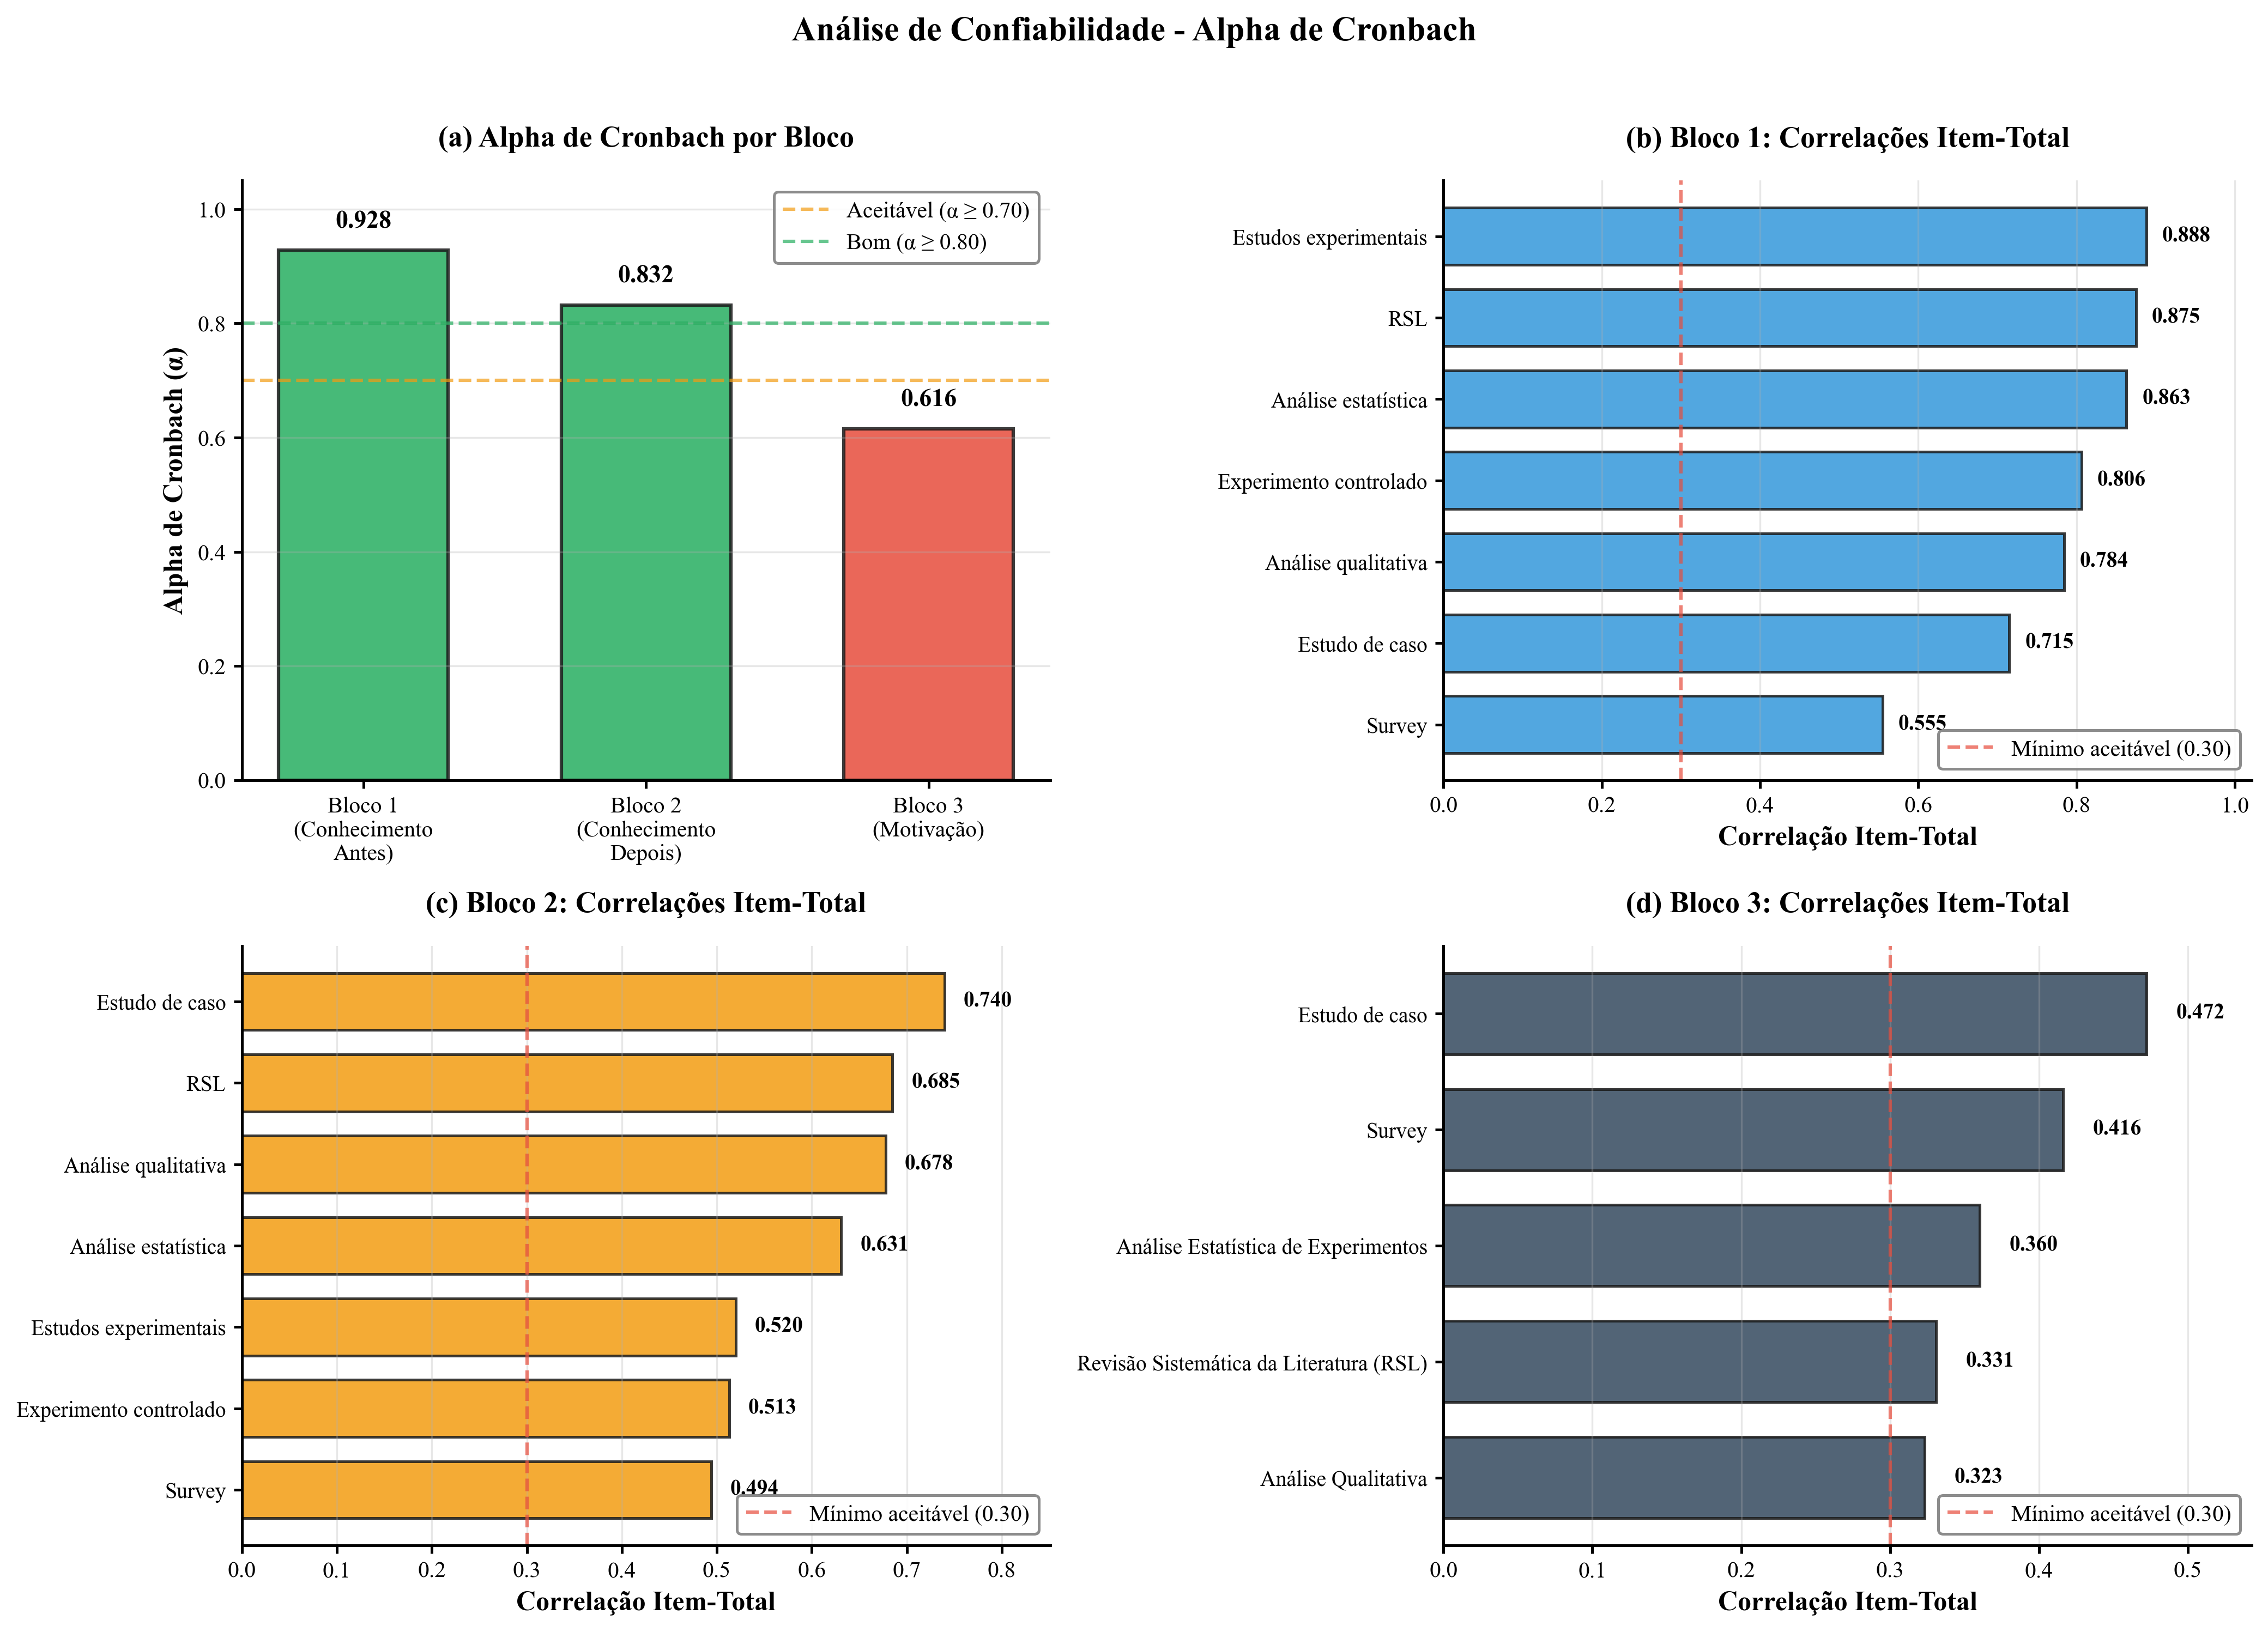

In [12]:
# Gráfico 1: Alpha de Cronbach por Bloco (Melhorado para artigo)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.patch.set_facecolor('white')

# Gráfico 1.1: Alpha de Cronbach
ax1 = axes[0, 0]
blocos = ['Bloco 1\n(Conhecimento\nAntes)', 
          'Bloco 2\n(Conhecimento\nDepois)', 
          'Bloco 3\n(Motivação)']
alphas = [alpha1, alpha2, alpha3]
# Cores baseadas na qualidade do alpha
colors_alpha = [colors_academic['accent3'] if a >= 0.80 
                else colors_academic['accent4'] if a >= 0.70 
                else colors_academic['accent2'] for a in alphas]

bars = ax1.bar(blocos, alphas, color=colors_alpha, alpha=0.85, 
               edgecolor=colors_academic['dark'], linewidth=1.5, width=0.6)
ax1.axhline(y=0.70, color=colors_academic['accent4'], linestyle='--', 
            linewidth=1.5, label='Aceitável (α ≥ 0.70)', alpha=0.7)
ax1.axhline(y=0.80, color=colors_academic['accent3'], linestyle='--', 
            linewidth=1.5, label='Bom (α ≥ 0.80)', alpha=0.7)
ax1.set_ylabel('Alpha de Cronbach (α)', fontsize=12, fontweight='bold')
ax1.set_title('(a) Alpha de Cronbach por Bloco', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='upper right', frameon=True, fancybox=True, shadow=False, 
          framealpha=0.9, edgecolor='gray')
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adicionar valores nas barras
for bar, alpha in zip(bars, alphas):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{alpha:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Gráfico 1.2: Correlações Item-Total (Bloco 1)
ax2 = axes[0, 1]
if analise_bloco1 is not None:
    corr_bloco1 = analise_bloco1['Correlação Item-Total'].sort_values()
    y_pos = range(len(corr_bloco1))
    bars2 = ax2.barh(y_pos, corr_bloco1.values, color=colors_academic['accent1'], 
                     alpha=0.85, edgecolor=colors_academic['dark'], linewidth=1.2, height=0.7)
    ax2.set_yticks(y_pos)
    # Encurtar labels para melhor visualização
    labels_short = [label.replace(' (antes)', '') for label in corr_bloco1.index]
    ax2.set_yticklabels(labels_short, fontsize=9.5)
    ax2.set_xlabel('Correlação Item-Total', fontsize=12, fontweight='bold')
    ax2.set_title('(b) Bloco 1: Correlações Item-Total', fontsize=13, fontweight='bold', pad=15)
    ax2.axvline(x=0.30, color=colors_academic['accent2'], linestyle='--', 
                linewidth=1.5, label='Mínimo aceitável (0.30)', alpha=0.7)
    ax2.legend(loc='lower right', frameon=True, fancybox=True, shadow=False, 
              framealpha=0.9, edgecolor='gray')
    ax2.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.8)
    ax2.set_xlim(0, max(corr_bloco1.values) * 1.15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Adicionar valores
    for i, (idx, val) in enumerate(corr_bloco1.items()):
        ax2.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9.5, fontweight='bold')

# Gráfico 1.3: Correlações Item-Total (Bloco 2)
ax3 = axes[1, 0]
if analise_bloco2 is not None:
    corr_bloco2 = analise_bloco2['Correlação Item-Total'].sort_values()
    y_pos = range(len(corr_bloco2))
    bars3 = ax3.barh(y_pos, corr_bloco2.values, color=colors_academic['accent4'], 
                     alpha=0.85, edgecolor=colors_academic['dark'], linewidth=1.2, height=0.7)
    ax3.set_yticks(y_pos)
    labels_short = [label.replace(' (depois)', '') for label in corr_bloco2.index]
    ax3.set_yticklabels(labels_short, fontsize=9.5)
    ax3.set_xlabel('Correlação Item-Total', fontsize=12, fontweight='bold')
    ax3.set_title('(c) Bloco 2: Correlações Item-Total', fontsize=13, fontweight='bold', pad=15)
    ax3.axvline(x=0.30, color=colors_academic['accent2'], linestyle='--', 
                linewidth=1.5, label='Mínimo aceitável (0.30)', alpha=0.7)
    ax3.legend(loc='lower right', frameon=True, fancybox=True, shadow=False, 
              framealpha=0.9, edgecolor='gray')
    ax3.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.8)
    ax3.set_xlim(0, max(corr_bloco2.values) * 1.15)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Adicionar valores
    for i, (idx, val) in enumerate(corr_bloco2.items()):
        ax3.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9.5, fontweight='bold')

# Gráfico 1.4: Correlações Item-Total (Bloco 3)
ax4 = axes[1, 1]
if analise_bloco3 is not None:
    corr_bloco3 = analise_bloco3['Correlação Item-Total'].sort_values()
    y_pos = range(len(corr_bloco3))
    bars4 = ax4.barh(y_pos, corr_bloco3.values, color=colors_academic['secondary'], 
                     alpha=0.85, edgecolor=colors_academic['dark'], linewidth=1.2, height=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(corr_bloco3.index, fontsize=9.5)
    ax4.set_xlabel('Correlação Item-Total', fontsize=12, fontweight='bold')
    ax4.set_title('(d) Bloco 3: Correlações Item-Total', fontsize=13, fontweight='bold', pad=15)
    ax4.axvline(x=0.30, color=colors_academic['accent2'], linestyle='--', 
                linewidth=1.5, label='Mínimo aceitável (0.30)', alpha=0.7)
    ax4.legend(loc='lower right', frameon=True, fancybox=True, shadow=False, 
              framealpha=0.9, edgecolor='gray')
    ax4.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.8)
    ax4.set_xlim(0, max(corr_bloco3.values) * 1.15)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # Adicionar valores
    for i, (idx, val) in enumerate(corr_bloco3.items()):
        ax4.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9.5, fontweight='bold')

plt.suptitle('Análise de Confiabilidade - Alpha de Cronbach', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('../img/cronbach_alpha_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()


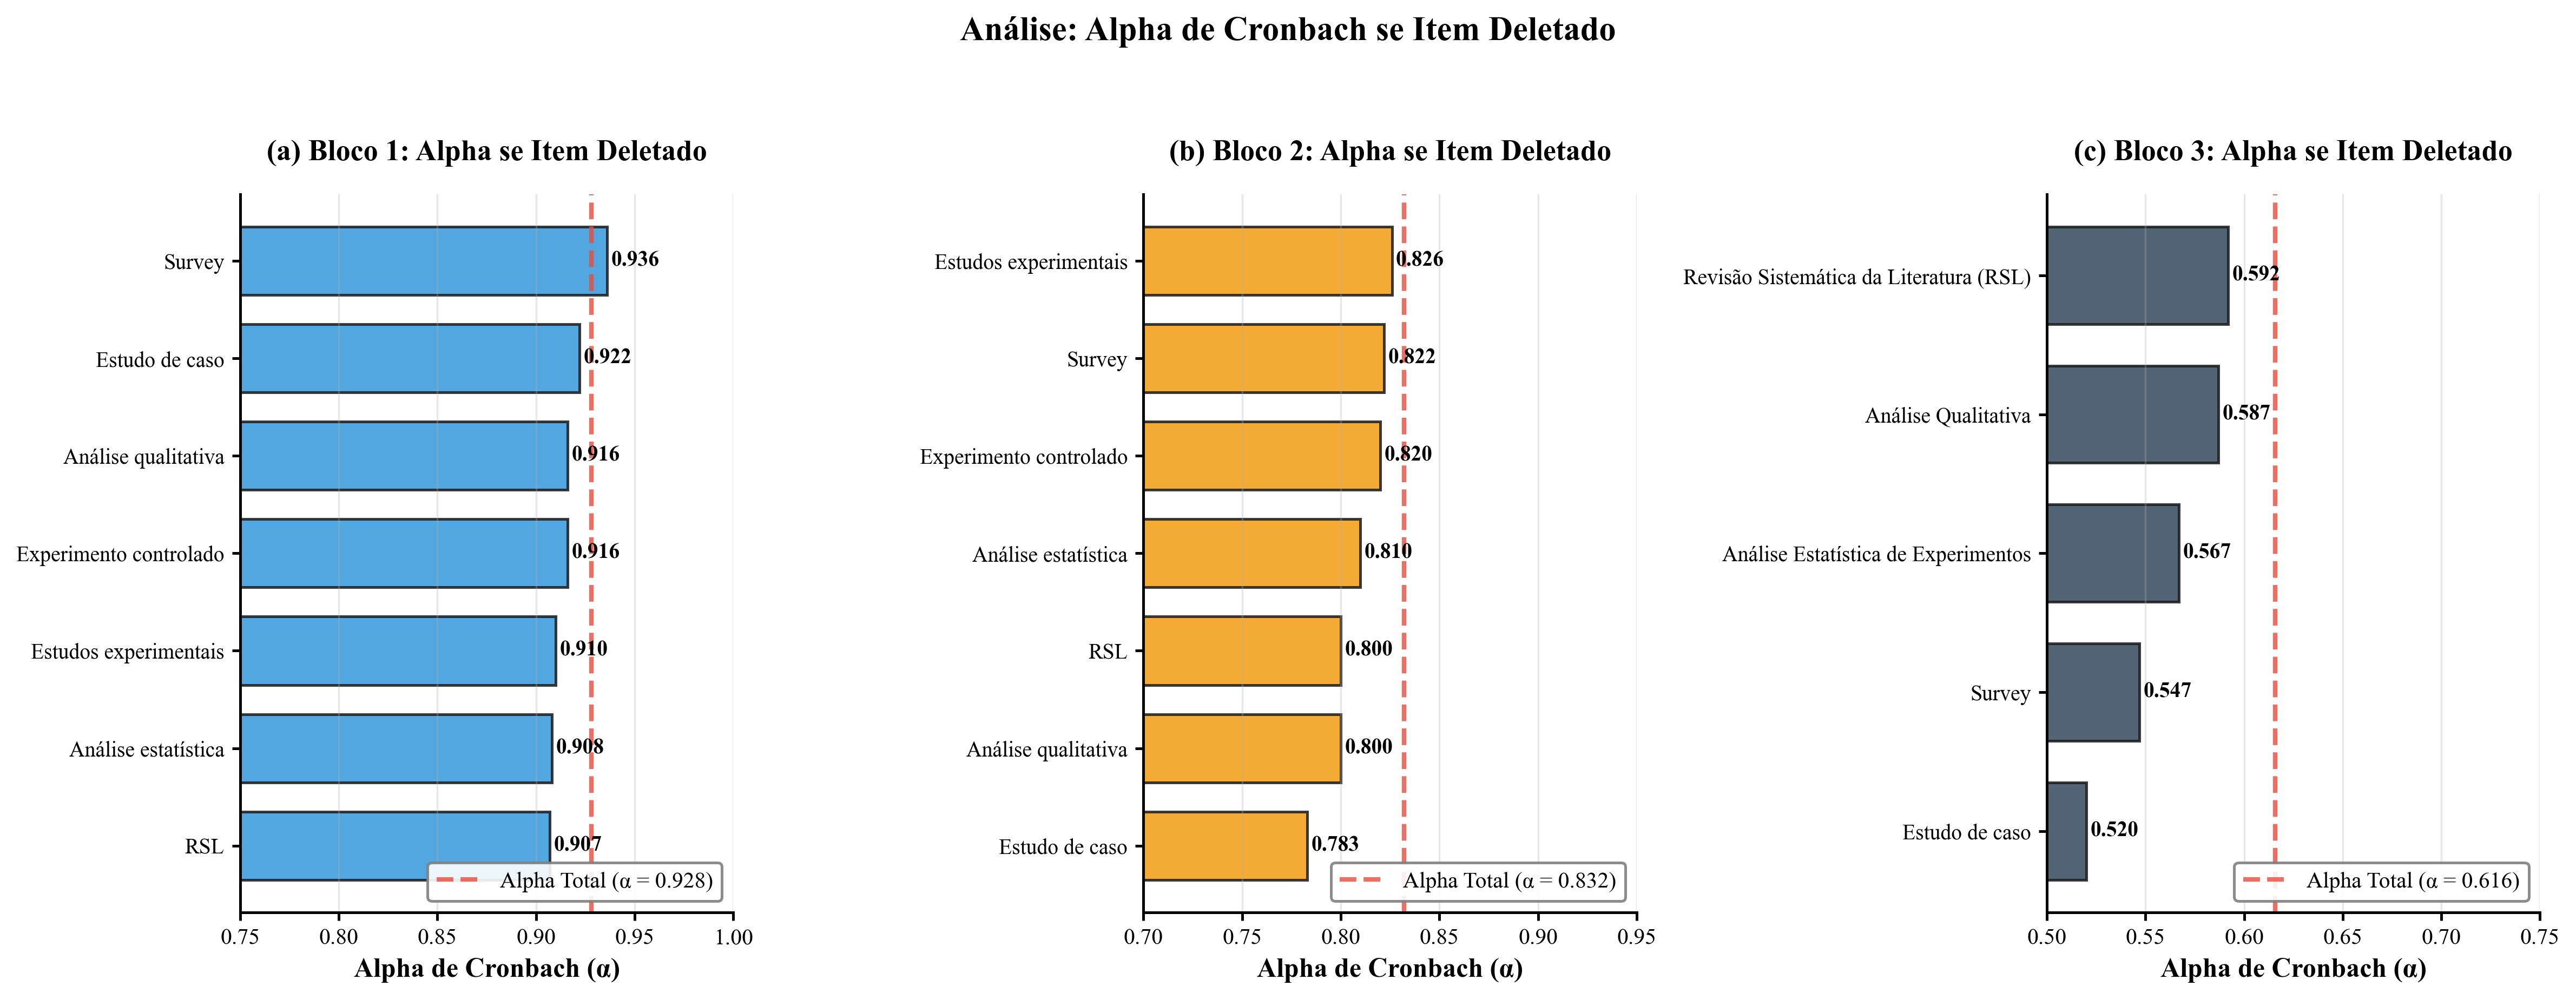


INTERPRETAÇÃO: Alpha se Item Deletado
Se o alpha aumenta ao deletar um item, esse item pode estar reduzindo
a consistência interna e pode ser considerado para remoção.


In [13]:
# Gráfico 2: Alpha se Item Deletado (Melhorado para artigo)
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.patch.set_facecolor('white')

# Bloco 1
ax1 = axes[0]
if analise_bloco1 is not None:
    alpha_del_bloco1 = analise_bloco1['Alpha se Item Deletado'].sort_values()
    alpha_total_bloco1 = alpha1
    
    y_pos = range(len(alpha_del_bloco1))
    bars1 = ax1.barh(y_pos, alpha_del_bloco1.values, 
                     color=colors_academic['accent1'], alpha=0.85, 
                     edgecolor=colors_academic['dark'], linewidth=1.2, height=0.7)
    ax1.axvline(x=alpha_total_bloco1, color=colors_academic['accent2'], 
                linestyle='--', linewidth=2, 
                label=f'Alpha Total (α = {alpha_total_bloco1:.3f})', alpha=0.8)
    ax1.set_yticks(y_pos)
    labels_short = [label.replace(' (antes)', '') for label in alpha_del_bloco1.index]
    ax1.set_yticklabels(labels_short, fontsize=9.5)
    ax1.set_xlabel('Alpha de Cronbach (α)', fontsize=12, fontweight='bold')
    ax1.set_title('(a) Bloco 1: Alpha se Item Deletado', fontsize=13, fontweight='bold', pad=15)
    ax1.legend(loc='lower right', frameon=True, fancybox=True, shadow=False, 
              framealpha=0.9, edgecolor='gray')
    ax1.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.8)
    ax1.set_xlim(0.75, 1.0)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Adicionar valores
    for i, (idx, val) in enumerate(alpha_del_bloco1.items()):
        ax1.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9.5, fontweight='bold')

# Bloco 2
ax2 = axes[1]
if analise_bloco2 is not None:
    alpha_del_bloco2 = analise_bloco2['Alpha se Item Deletado'].sort_values()
    alpha_total_bloco2 = alpha2
    
    y_pos = range(len(alpha_del_bloco2))
    bars2 = ax2.barh(y_pos, alpha_del_bloco2.values, 
                     color=colors_academic['accent4'], alpha=0.85, 
                     edgecolor=colors_academic['dark'], linewidth=1.2, height=0.7)
    ax2.axvline(x=alpha_total_bloco2, color=colors_academic['accent2'], 
                linestyle='--', linewidth=2, 
                label=f'Alpha Total (α = {alpha_total_bloco2:.3f})', alpha=0.8)
    ax2.set_yticks(y_pos)
    labels_short = [label.replace(' (depois)', '') for label in alpha_del_bloco2.index]
    ax2.set_yticklabels(labels_short, fontsize=9.5)
    ax2.set_xlabel('Alpha de Cronbach (α)', fontsize=12, fontweight='bold')
    ax2.set_title('(b) Bloco 2: Alpha se Item Deletado', fontsize=13, fontweight='bold', pad=15)
    ax2.legend(loc='lower right', frameon=True, fancybox=True, shadow=False, 
              framealpha=0.9, edgecolor='gray')
    ax2.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.8)
    ax2.set_xlim(0.70, 0.95)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Adicionar valores
    for i, (idx, val) in enumerate(alpha_del_bloco2.items()):
        ax2.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9.5, fontweight='bold')

# Bloco 3
ax3 = axes[2]
if analise_bloco3 is not None:
    alpha_del_bloco3 = analise_bloco3['Alpha se Item Deletado'].sort_values()
    alpha_total_bloco3 = alpha3
    
    y_pos = range(len(alpha_del_bloco3))
    bars3 = ax3.barh(y_pos, alpha_del_bloco3.values, 
                     color=colors_academic['secondary'], alpha=0.85, 
                     edgecolor=colors_academic['dark'], linewidth=1.2, height=0.7)
    ax3.axvline(x=alpha_total_bloco3, color=colors_academic['accent2'], 
                linestyle='--', linewidth=2, 
                label=f'Alpha Total (α = {alpha_total_bloco3:.3f})', alpha=0.8)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(alpha_del_bloco3.index, fontsize=9.5)
    ax3.set_xlabel('Alpha de Cronbach (α)', fontsize=12, fontweight='bold')
    ax3.set_title('(c) Bloco 3: Alpha se Item Deletado', fontsize=13, fontweight='bold', pad=15)
    ax3.legend(loc='lower right', frameon=True, fancybox=True, shadow=False, 
              framealpha=0.9, edgecolor='gray')
    ax3.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.8)
    ax3.set_xlim(0.50, 0.75)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Adicionar valores
    for i, (idx, val) in enumerate(alpha_del_bloco3.items()):
        ax3.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9.5, fontweight='bold')

plt.suptitle('Análise: Alpha de Cronbach se Item Deletado', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('../img/cronbach_alpha_if_deleted.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("\n" + "="*70)
print("INTERPRETAÇÃO: Alpha se Item Deletado")
print("="*70)
print("Se o alpha aumenta ao deletar um item, esse item pode estar reduzindo")
print("a consistência interna e pode ser considerado para remoção.")
print("="*70)


## Tabelas de Confiabilidade

Gerar tabelas formatadas com os resultados.


In [14]:
# Criar tabela resumo final
print("\n" + "="*80)
print("TABELA RESUMO - ALPHA DE CRONBACH")
print("="*80)

tabela_resumo = pd.DataFrame({
    'Bloco': ['Bloco 1 - Conhecimento Antes', 
              'Bloco 2 - Conhecimento Depois', 
              'Bloco 3 - Motivação'],
    'N Items': [bloco1_clean.shape[1], bloco2_clean.shape[1], bloco3_clean.shape[1]],
    'N Respondentes': [bloco1_clean.shape[0], bloco2_clean.shape[0], bloco3_clean.shape[0]],
    'Alpha de Cronbach': [alpha1, alpha2, alpha3],
    'Interpretação': [
        'Excelente' if alpha1 >= 0.90 else 'Boa' if alpha1 >= 0.80 else 'Aceitável' if alpha1 >= 0.70 else 'Questionável' if alpha1 >= 0.60 else 'Inadequada',
        'Excelente' if alpha2 >= 0.90 else 'Boa' if alpha2 >= 0.80 else 'Aceitável' if alpha2 >= 0.70 else 'Questionável' if alpha2 >= 0.60 else 'Inadequada',
        'Excelente' if alpha3 >= 0.90 else 'Boa' if alpha3 >= 0.80 else 'Aceitável' if alpha3 >= 0.70 else 'Questionável' if alpha3 >= 0.60 else 'Inadequada'
    ]
})

tabela_resumo['Alpha de Cronbach'] = tabela_resumo['Alpha de Cronbach'].round(3)
print(tabela_resumo.to_string(index=False))
print("="*80)



TABELA RESUMO - ALPHA DE CRONBACH
                        Bloco  N Items  N Respondentes  Alpha de Cronbach Interpretação
 Bloco 1 - Conhecimento Antes        7              21              0.928     Excelente
Bloco 2 - Conhecimento Depois        7              21              0.832           Boa
          Bloco 3 - Motivação        5              21              0.616  Questionável


In [16]:
# Tabelas detalhadas por bloco
print("\n" + "="*80)
print("TABELAS DETALHADAS POR BLOCO")
print("="*80)

for nome_bloco, df_analise in [("BLOCO 1 - CONHECIMENTO ANTES", analise_bloco1),
                                ("BLOCO 2 - CONHECIMENTO DEPOIS", analise_bloco2),
                                ("BLOCO 3 - MOTIVAÇÃO", analise_bloco3)]:
    if df_analise is not None:
        print(f"\n{nome_bloco}")
        print("-"*80)
        print(df_analise.to_string())
        print("-"*80)



TABELAS DETALHADAS POR BLOCO

BLOCO 1 - CONHECIMENTO ANTES
--------------------------------------------------------------------------------
                                Média  Desvio Padrão  Mínimo  Máximo  Correlação Item-Total  Alpha se Item Deletado
Estudos experimentais (antes)   1.000          1.225     0.0     4.0                  0.888                   0.910
Experimento controlado (antes)  1.333          1.278     0.0     5.0                  0.806                   0.916
Estudo de caso (antes)          1.571          1.599     0.0     5.0                  0.715                   0.922
Survey (antes)                  1.571          1.399     0.0     5.0                  0.555                   0.936
Análise estatística (antes)     1.810          1.887     0.0     5.0                  0.863                   0.908
Análise qualitativa (antes)     1.667          1.592     0.0     5.0                  0.784                   0.916
RSL (antes)                     1.571          

## Interpretação e Recomendações

### Interpretação dos Resultados:

1. **Alpha de Cronbach (α)**: Mede a consistência interna dos itens
   - Valores próximos a 1 indicam alta consistência
   - Valores abaixo de 0.70 podem indicar problemas de confiabilidade

2. **Correlação Item-Total**: 
   - Valores acima de 0.30 são geralmente aceitáveis
   - Valores muito baixos podem indicar que o item não mede o mesmo constructo

3. **Alpha se Item Deletado**:
   - Se aumenta ao deletar um item, esse item pode estar reduzindo a consistência
   - Se diminui, o item está contribuindo positivamente para a confiabilidade

### Recomendações:

- **Itens com correlação item-total < 0.30**: Considerar revisão ou remoção
- **Itens que aumentam o alpha quando deletados**: Avaliar necessidade de remoção
- **Alpha < 0.70**: Revisar itens ou considerar reformulação do instrumento
